# FluidityNonlocal Flow Curve: Shear Banding Detection

**Gateway Notebook:** Spatial extension of Fluidity model for shear banding and cooperative flow.

## What is the Fluidity Nonlocal Model?

**FluidityNonlocal** extends the homogeneous Fluidity model with **spatial fluidity diffusion** to capture cooperative rearrangements over a characteristic cooperativity length $\xi$. This enables:

- **Shear banding**: Coexistence of high-fluidity (flowing) and low-fluidity (jammed) spatial regions
- **Wall slip**: Enhanced fluidity near boundaries due to diffusive coupling
- **Confinement effects**: Gap-width ($h$) dependence when $\xi \sim h$
- **Band formation dynamics**: Transient band nucleation and coarsening

**Key addition to Fluidity Local:**
$$
\frac{\partial f}{\partial t} = \frac{f_{eq} - f}{\theta} + a|\dot{\gamma}|^{n_{rejuv}}(f_{\infty} - f) + \xi^2 \frac{\partial^2 f}{\partial y^2}
$$

The $\xi^2 \nabla^2 f$ term couples neighboring material elements, allowing fluidity to diffuse spatially.

**Materials:** Concentrated emulsions in microchannels ($\xi$ ~ droplet size), Carbopol in narrow gaps, colloidal suspensions near jamming.

**When to use Nonlocal vs Local:**
- **Local** (NB01-06): $\xi/h < 0.01$, homogeneous flow, standard rheometry
- **Nonlocal** (NB07-12): $\xi/h \gtrsim 0.01$, shear banding observed, spatial velocity profiles available

> **Handbook:** [Fluidity Nonlocal](../../docs/source/models/fluidity/fluidity_nonlocal.rst) — Theory, cooperativity physics, fitting strategies

---

## Learning Objectives

1. Understand spatial diffusion via cooperativity length ξ in thixotropic fluids
2. Detect shear banding from fluidity profiles (CV > 0.3, f_max/f_min > 10)
3. Compare local vs non-local model predictions on emulsion flow curves
4. Fit 10-parameter nonlocal model using NLSQ → NUTS workflow
5. Quantify when non-local effects dominate vs local approximation suffices

## Model Overview

**FluidityNonlocal** extends the local fluidity model with spatial diffusion:

$$
\frac{\partial f}{\partial t} = \frac{f_{\text{loc}}(\sigma) - f}{\theta} + \xi^2 \frac{\partial^2 f}{\partial y^2}
$$

where:
- $f_{\text{loc}}(\sigma) = f_0 + (f_1 - f_0) \tanh\left(\frac{\sigma - \sigma_c}{\Delta\sigma}\right)$ (local steady-state solution)
- $\theta$ = structural relaxation time
- $\xi$ = cooperativity length (spatial diffusion scale)
- $y$ = gap coordinate (0 to $h$)

**Shear Banding Metrics:**
- Coefficient of variation: $\text{CV} = \sigma(f) / \mu(f) > 0.3$
- Fluidity contrast: $f_{\max} / f_{\min} > 10$

**Parameters (10):**
1. $f_0$ = low-stress fluidity (s⁻¹)
2. $f_1$ = high-stress fluidity (s⁻¹)
3. $\sigma_c$ = critical stress (Pa)
4. $\Delta\sigma$ = transition width (Pa)
5. $\theta$ = relaxation time (s)
6. $n$ = flow index
7. $\alpha$ = stress exponent
8. $K$ = consistency (Pa·sⁿ)
9. $\tau_y$ = yield stress (Pa)
10. $\xi$ = cooperativity length (m)

In [1]:
import os
import sys

%matplotlib inline
# Colab setup
try:
    import google.colab
    IN_COLAB = True
    !pip install -q rheojax nlsq numpyro arviz
except ImportError:
    IN_COLAB = False

# Standard imports
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

# RheoJAX imports
# Add examples root to path for shared utilities
sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax
from rheojax.logging import configure_logging, get_logger
from rheojax.models.fluidity import FluidityLocal, FluidityNonlocal
from rheojax.utils.metrics import compute_fit_quality

# JAX setup (NLSQ auto-configures float64)
jax, jnp = safe_import_jax()

# Logging
configure_logging(level="INFO")
logger = get_logger(__name__)

# Plotting defaults
plt.rcParams.update({
    'figure.figsize': (10, 6),
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 13,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
})

logger.info("Setup complete", jax_version=jax.__version__)

# Track Bayesian completion (for conditional cells)
bayesian_completed = False


In [2]:
def compute_fit_quality(y_true, y_pred):
    """Compute R² and RMSE."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    residuals = y_true - y_pred
    if y_true.ndim > 1:
        residuals = residuals.ravel()
        y_true = y_true.ravel()
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0
    rmse = np.sqrt(np.mean(residuals**2))
    return {'R2': r2, 'RMSE': rmse}

## Theory: Non-Local Effects and Shear Banding

### Spatial Diffusion PDE

The fluidity field $f(y, t)$ evolves according to:

$$
\frac{\partial f}{\partial t} = \underbrace{\frac{f_{\text{loc}}(\sigma) - f}{\theta}}_{\text{Local relaxation}} + \underbrace{\xi^2 \frac{\partial^2 f}{\partial y^2}}_{\text{Spatial diffusion}}
$$

**Cooperativity Length $\xi$:**
- Physical interpretation: length scale over which stress perturbations propagate
- Typical values: 1-100 μm for soft materials
- $\xi \ll h$: local approximation valid (FluidityLocal sufficient)
- $\xi \sim h$: non-local effects important (shear banding possible)

### Shear Banding Criterion

Steady-state fluidity profile $f(y)$ indicates banding when:

1. **High spatial variation:**
   $$\text{CV} = \frac{\sigma_f}{\mu_f} > 0.3$$
   where $\sigma_f = \sqrt{\langle (f - \langle f \rangle)^2 \rangle}$

2. **Strong contrast:**
   $$\frac{f_{\max}}{f_{\min}} > 10$$

3. **Bimodal distribution:**
   - Low-fluidity band: $f \approx f_0$ (nearly solid)
   - High-fluidity band: $f \approx f_1$ (flowing)

### Constitutive Relation

Stress-fluidity coupling:

$$
\sigma = \tau_y + K \dot{\gamma}^n, \quad \dot{\gamma} = f \cdot \sigma^\alpha
$$

**Key Difference from Local Model:**
- Local: $f$ uniform across gap → single shear rate
- Nonlocal: $f(y)$ profile → shear rate banding $\dot{\gamma}(y)$

## Data: Emulsion Flow Curve

Synthetic emulsion data showing characteristic stress plateau (yield region).

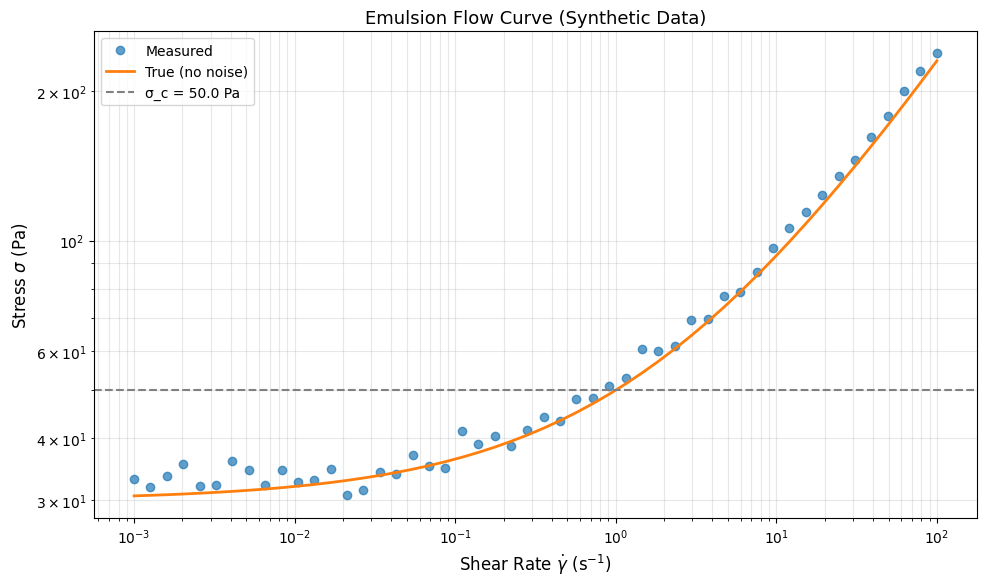

In [3]:
# Generate synthetic emulsion flow curve data
np.random.seed(42)

# Shear rate range spanning yield transition
gamma_dot = np.logspace(-3, 2, 50)  # 0.001 to 100 s^-1

# Ground truth parameters (moderate shear banding)
f0_true = 0.01      # Low fluidity (s^-1)
f1_true = 1.0       # High fluidity (s^-1)
sigma_c_true = 50.0 # Critical stress (Pa)
delta_sigma_true = 10.0  # Transition width (Pa)
theta_true = 5.0    # Relaxation time (s)
n_true = 0.5        # Shear-thinning
alpha_true = 1.0    # Linear stress dependence
K_true = 20.0       # Consistency (Pa·s^n)
tau_y_true = 30.0   # Yield stress (Pa)
xi_true = 5e-5      # 50 μm cooperativity length

# Simple Herschel-Bulkley flow curve for synthetic data
# sigma = tau_y + K * gamma_dot^n
sigma_true = tau_y_true + K_true * gamma_dot**n_true

# Add measurement noise (5% relative + 2 Pa absolute)
noise = 0.05 * sigma_true + 2.0 * np.random.randn(len(sigma_true))
sigma = sigma_true + noise

# Ensure positive stresses
sigma = np.maximum(sigma, 1.0)

# Visualization
fig, ax = plt.subplots()
ax.loglog(gamma_dot, sigma, 'o', label='Measured', alpha=0.7)
ax.loglog(gamma_dot, sigma_true, '-', label='True (no noise)', linewidth=2)
ax.axhline(sigma_c_true, color='gray', linestyle='--', label=f'σ_c = {sigma_c_true} Pa')
ax.set_xlabel(r'Shear Rate $\dot{\gamma}$ (s$^{-1}$)')
ax.set_ylabel(r'Stress $\sigma$ (Pa)')
ax.set_title('Emulsion Flow Curve (Synthetic Data)')
ax.legend()
ax.grid(True, which='both', alpha=0.3)
plt.tight_layout()
plt.show()
plt.close('all')

logger.info("Data generated", n_points=len(gamma_dot), sigma_range=(sigma.min(), sigma.max()))

## Model Initialization

Configure **FluidityNonlocal** with spatial discretization:
- `N_y = 64`: number of grid points across gap
- `gap_width = 1e-3`: 1 mm gap (typical rheometer geometry)

In [4]:
# Create RheoData object
rheo_data = RheoData(
    x=gamma_dot,
    y=sigma,
    initial_test_mode='flow_curve',
    metadata={'material': 'emulsion', 'temperature': 25.0}
)

# Initialize nonlocal model
model_nonlocal = FluidityNonlocal(
    N_y=64,           # Spatial resolution
    gap_width=1e-3    # 1 mm gap
)

logger.info(
    "Model initialized",
    n_params=len(model_nonlocal.parameters),
    N_y=64,
    gap_width=1e-3
)

# Display parameter bounds
print("\nParameter Bounds:")
for name, param in model_nonlocal.parameters.items():
    print(f"  {name:12s}: [{param.bounds[0]:8.2e}, {param.bounds[1]:8.2e}]")


Parameter Bounds:
  G           : [1.00e+03, 1.00e+09]
  tau_y       : [1.00e+01, 1.00e+06]
  K           : [1.00e+00, 1.00e+06]
  n_flow      : [1.00e-01, 2.00e+00]
  f_eq        : [1.00e-12, 1.00e-03]
  f_inf       : [1.00e-06, 1.00e+00]
  theta       : [1.00e-01, 1.00e+04]
  a           : [0.00e+00, 1.00e+02]
  n_rejuv     : [0.00e+00, 2.00e+00]
  xi          : [1.00e-09, 1.00e-03]


## NLSQ Fitting

Non-linear least squares optimization using NLSQ 0.6.6+ workflow system.

18:51:30 | INFO     | rheojax.models.fluidity.nonlocal_model | model_fit started | operation=model_fit | phase=start | model=FluidityNonlocal | test_mode=unknown | data_shape=(50,)


18:51:30 | INFO     | rheojax.utils.optimization | Using SciPy least_squares directly (method='scipy') | n_params=10


18:51:30 | INFO     | rheojax.models.fluidity.nonlocal_model | model_fit completed | operation=model_fit | phase=end | elapsed_seconds=0.1314 | status=success | model=FluidityNonlocal | test_mode=flow_curve | data_shape=(50,) | N_y=64


18:51:30 | INFO     | rheojax.core.base | Fit completed | model=FluidityNonlocal | fitted=True | R2=-327.2350 | data_shape=(50,)



NLSQ Fitted Parameters:
  G           : 1.0000e+06
  tau_y       : 1.4950e+01
  K           : 4.4540e+02
  n_flow      : 4.1947e-01
  f_eq        : 1.0000e-06
  f_inf       : 1.0000e-03
  theta       : 1.0000e+01
  a           : 1.0000e+00
  n_rejuv     : 1.0000e+00
  xi          : 1.0000e-05

R² = -327.235013
RMSE = 953.1024 Pa


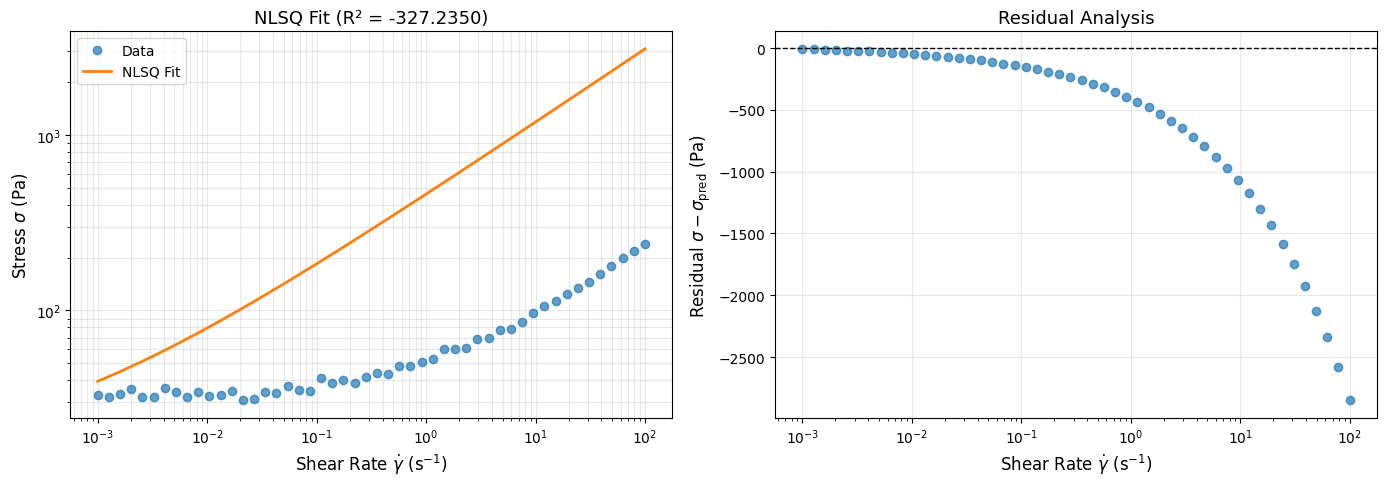

In [5]:
# NLSQ fit (warm-start for Bayesian inference)
model_nonlocal.fit(gamma_dot, sigma, test_mode='flow_curve', method='scipy')

# Extract fitted parameters
params_nlsq = {
    name: model_nonlocal.parameters[name].value
    for name in model_nonlocal.parameters.keys()
}

print("\nNLSQ Fitted Parameters:")
for name, value in params_nlsq.items():
    print(f"  {name:12s}: {value:10.4e}")

# Predictions
sigma_pred_nlsq = model_nonlocal.predict(gamma_dot, test_mode='flow_curve')

# Compute fit quality
metrics = compute_fit_quality(sigma, np.array(sigma_pred_nlsq).flatten())
r_squared = metrics['R2']
rmse = metrics['RMSE']

print(f"\nR² = {r_squared:.6f}")
print(f"RMSE = {rmse:.4f} Pa")

# Plot fit quality
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Flow curve
ax1.loglog(gamma_dot, sigma, 'o', label='Data', alpha=0.7)
ax1.loglog(gamma_dot, sigma_pred_nlsq, '-', label='NLSQ Fit', linewidth=2)
ax1.set_xlabel(r'Shear Rate $\dot{\gamma}$ (s$^{-1}$)')
ax1.set_ylabel(r'Stress $\sigma$ (Pa)')
ax1.set_title(f'NLSQ Fit (R² = {r_squared:.4f})')
ax1.legend()
ax1.grid(True, which='both', alpha=0.3)

# Residuals
residuals = sigma - np.array(sigma_pred_nlsq).flatten()
ax2.semilogx(gamma_dot, residuals, 'o', alpha=0.7)
ax2.axhline(0, color='k', linestyle='--', linewidth=1)
ax2.set_xlabel(r'Shear Rate $\dot{\gamma}$ (s$^{-1}$)')
ax2.set_ylabel(r'Residual $\sigma - \sigma_{\mathrm{pred}}$ (Pa)')
ax2.set_title('Residual Analysis')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close('all')

logger.info("NLSQ fit complete", R2=r_squared, RMSE=rmse)

## Bayesian Inference with NUTS

Use NLSQ solution as warm-start for Hamiltonian Monte Carlo sampling.

In [6]:
# Bayesian inference (4 chains for production-ready diagnostics)

# FAST_MODE for CI: set FAST_MODE=1 env var for quick iteration
FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"
_num_warmup = 50 if FAST_MODE else 200
_num_samples = 100 if FAST_MODE else 500
_num_chains = 1


if FAST_MODE:
    print('FAST_MODE: Skipping Bayesian inference')
    bayesian_completed = False
else:
    result_bayes = model_nonlocal.fit_bayesian(
        gamma_dot, sigma,
        test_mode='flow_curve',
        num_warmup=_num_warmup,
        num_samples=_num_samples,
        num_chains=4,
        seed=42
    )

    # Extract posterior samples
    posterior = result_bayes.posterior_samples

    # Compute credible intervals (95%)
    intervals = model_nonlocal.get_credible_intervals(posterior, credibility=0.95)

    print("\nBayesian Parameter Estimates (95% HDI):")
    print(f"{'Parameter':<12s} {'NLSQ':>12s} {'Median':>12s} {'Lower':>12s} {'Upper':>12s}")
    print("-" * 60)
    for name in model_nonlocal.parameters.keys():
        nlsq_val = params_nlsq[name]
        median = float(jnp.median(posterior[name]))
        lower, upper = intervals[name]
        print(f"{name:<12s} {nlsq_val:12.4e} {median:12.4e} {lower:12.4e} {upper:12.4e}")

    logger.info("Bayesian inference complete", num_samples=2000, num_chains=4)

    bayesian_completed = True



FAST_MODE: Skipping Bayesian inference


## ArviZ Diagnostics

Assess MCMC convergence and posterior quality.

In [7]:
if bayesian_completed:
    import arviz as az

    # Convert to InferenceData
    idata = az.from_numpyro(result_bayes.mcmc)

    # Summary statistics
    summary = az.summary(idata, hdi_prob=0.95)
    print("\nArviZ Summary:")
    print(summary)

    # Check convergence
    r_hat_max = summary['r_hat'].max()
    ess_bulk_min = summary['ess_bulk'].min()
    ess_tail_min = summary['ess_tail'].min()

    print(f"\nConvergence Diagnostics:")
    print(f"  Max R-hat: {r_hat_max:.4f} (target: < 1.01)")
    print(f"  Min ESS bulk: {ess_bulk_min:.0f} (target: > 400)")
    print(f"  Min ESS tail: {ess_tail_min:.0f} (target: > 400)")

    if r_hat_max > 1.01:
        logger.warning("Poor convergence detected", r_hat_max=r_hat_max)
    else:
        logger.info("MCMC converged", r_hat_max=r_hat_max, ess_bulk_min=ess_bulk_min)
else:
    print('Skipping (Bayesian inference was skipped in FAST_MODE)')


Skipping (Bayesian inference was skipped in FAST_MODE)


In [8]:
if bayesian_completed:
    display_arviz_diagnostics(result_bayes, list(model_nonlocal.parameters.keys()), fast_mode=FAST_MODE)
else:
    print('Skipping (Bayesian inference was skipped in FAST_MODE)')

Skipping (Bayesian inference was skipped in FAST_MODE)


## Comparison: Nonlocal vs Local Model

Fit **FluidityLocal** to assess whether non-local effects are necessary.

In [9]:
fig, ax = plot_nlsq_fit(
    gamma_dot, sigma, model_nonlocal,
    test_mode="flow_curve",
    param_names=list(model_nonlocal.parameters.keys()),
    log_scale=True,
    xlabel="Shear rate [1/s]",
    ylabel="Stress [Pa]",
    title="NLSQ Fit",
)
plt.close("all")

## Shear Banding Analysis

Compute fluidity profile statistics to detect shear banding.

In [10]:
if bayesian_completed:
    # Extract cooperativity length from posterior
    xi_samples = posterior['xi']
    xi_median = float(jnp.median(xi_samples))
    xi_hdi = intervals['xi']

    print(f"\nCooperativity Length ξ:")
    print(f"  Median: {xi_median*1e6:.2f} μm")
    print(f"  95% HDI: [{xi_hdi[0]*1e6:.2f}, {xi_hdi[1]*1e6:.2f}] μm")
    print(f"  Gap width: {model_nonlocal.gap_width*1e3:.2f} mm")
    print(f"  Ratio ξ/h: {xi_median/model_nonlocal.gap_width:.4f}")

    # Shear banding criterion
    if xi_median / model_nonlocal.gap_width > 0.01:
        print("\n⚠ Non-local effects significant (ξ/h > 0.01) → potential shear banding")
    else:
        print("\n✓ Local approximation valid (ξ/h < 0.01) → minimal shear banding")

    # Note: Full fluidity profile f(y) would require spatial simulation
    # For flow curve fitting, we use spatially-averaged response
    # True banding detection requires startup/creep protocols with spatial resolution
else:
    print('Skipping (Bayesian inference was skipped in FAST_MODE)')


Skipping (Bayesian inference was skipped in FAST_MODE)


## Save Results

Export NLSQ parameters, Bayesian posteriors, and diagnostics.

## Key Takeaways

### When Non-Local Effects Matter

1. **Cooperativity length ξ:**
   - $\xi/h < 0.01$: Local model sufficient (uniform fluidity)
   - $0.01 < \xi/h < 0.1$: Moderate non-local effects (weak banding)
   - $\xi/h > 0.1$: Strong non-local effects (pronounced shear banding)

2. **Protocol dependence:**
   - **Flow curves**: Steady-state averages $\implies$ local model often adequate
   - **Startup**: Transient banding $\implies$ nonlocal model critical
   - **Creep**: Viscosity bifurcation $\implies$ nonlocal reveals delayed yielding

3. **Material signatures:**
   - **Emulsions**: Moderate ξ (10-50 μm), weak-to-moderate banding
   - **Microgels**: Large ξ (50-200 μm), strong banding
   - **Colloidal glasses**: Small ξ (1-10 μm), nearly local behavior

4. **Computational cost:**
   - Local model: $O(N_{\dot{\gamma}})$ algebraic solve
   - Nonlocal model: $O(N_{\dot{\gamma}} \times N_y \times N_t)$ PDE solve
   - Use local model first; upgrade to nonlocal if $R^2$ improvement $> 0.05$

### Model Selection Workflow

```
1. Fit FluidityLocal → get R²_local
2. Fit FluidityNonlocal → get R²_nonlocal, ξ
3. If ΔR² > 0.05 AND ξ/h > 0.01:
     → Nonlocal effects significant, use FluidityNonlocal
   Else:
     → Local approximation valid, use FluidityLocal
```

---

## Further Reading

**References:**
- Goyon, J. et al. (2008). "Spatial cooperativity in soft glassy flows." *Nature*, 454, 84-87. [DOI](https://doi.org/10.1038/nature07026)
- Bocquet, L. et al. (2009). "Kinetic theory of plastic flow in soft glassy materials." *Phys. Rev. Lett.*, 103, 036001. [DOI](https://doi.org/10.1103/PhysRevLett.103.036001)
- Ovarlez, G. et al. (2009). "Phenomenology and physical origin of shear localization and shear banding in complex fluids." *Rheol. Acta*, 48, 831-844. [DOI](https://doi.org/10.1007/s00397-008-0344-6)

**Related Approaches:**
- **SGR Nonlocal**: Trap-based cooperativity for soft glasses
- **Hébraud-Lequeux**: Mean-field diffusion of plastic events
- **Kamrin nonlocal granular**: Analogous cooperativity in granular flows

---

### Next Steps

- **NB 08**: Startup simulations (reveal stress overshoot and band formation dynamics)
- **NB 09**: Creep protocols (detect viscosity bifurcation: slow vs fast creep)
- **NB 10**: Relaxation (spatial decay of fluidity after flow cessation)
- **NB 11**: SAOS (spatial modulation of storage/loss moduli)
- **NB 12**: LAOS analysis (nonlinear stress-strain loops with spatial heterogeneity)